## Import necessary libraries & download dataset

In [4]:
import nltk
import re
import os
from functools import reduce

nltk.download('punkt')
os.chdir("/content/")
!git clone https://github.com/nmng108/ComOM.git

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Cloning into 'ComOM'...
remote: Enumerating objects: 93, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 93 (delta 0), reused 93 (delta 0), pack-reused 0
Receiving objects: 100% (93/93), 334.44 KiB | 3.93 MiB/s, done.


In [5]:
# !pip install transformers
# !git clone --single-branch --branch fast_tokenizers_BARTpho_PhoBERT_BERTweet https://github.com/datquocnguyen/transformers.git
# !pip install -e "/content/transformers"
# !pip install underthesea

In [6]:
# import underthesea as uts
# from underthesea import word_tokenize, sent_tokenize

In [7]:
# Test libraries's APIs
# Conclusion 1: both the NLP libs (nltk, uts) cannot sent_tokenize correctly in a sentence containing citations.
# uts.word_tokenize("   2.   A noi: \"Samsung Galaxy Y10 Plus co kich thứơc man hinh 2.8mm, kha an tuong vi nho hon dang ke.\", va dung nhu vay.")


In [8]:
# !pip install py_vncorenlp

In [9]:
# import py_vncorenlp
# import os

# # Automatically download VnCoreNLP components from the original repository
# # and save them in some local machine folder
# os.mkdir('/content/vncorenlp')
# py_vncorenlp.download_model(save_dir='/content/vncorenlp')

# # Load the word and sentence segmentation component
# rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir='/content/vncorenlp')

In [10]:
# text = "title: So sánh Galaxy Z Fold 4 và iPhone 13 Pro Max: Flagship nào hấp dẫn hơn?	title : So sánh Galaxy Z Fold 4 và iPhone 13 Pro Max : Flagship nào hấp dẫn hơn ?"
# output = rdrsegmenter.word_segment(text)

# output
# # ['Ông Nguyễn_Khắc_Chúc đang làm_việc tại Đại_học Quốc_gia Hà_Nội .', 'Bà Lan , vợ ông Chúc , cũng làm_việc tại đây .']

### Load the Vietnamese stopword list

In [11]:
abs_path: str = "/content/ComOM/vietnamese-stopwords.txt"

if not os.path.isfile(abs_path):
  print(f"Cannot load set of stopwords as the file \"{abs_path}\" is not found")
  exit(-1)

try:
  with open(abs_path, mode="r") as file:
    global stopwords
    stopwords = file.read().split("\n")
    stopwords = set([w.lower() for w in stopwords])

except Exception as e:
  print(f"Error raised while reading {abs_path}: {str(e)}")

print(f"Loaded {len(stopwords)} stopwords in \"{abs_path}\"")

Loaded 1942 stopwords in "/content/ComOM/vietnamese-stopwords.txt"


## A. Load & parse data

##### Sample training dataset

In [12]:
# Used for quick tests without importing/reading files
sample_dataset: str = """
title: So sánh Galaxy Z Fold 4 và iPhone 13 Pro Max: Flagship nào hấp dẫn hơn?	title : So sánh Galaxy Z Fold 4 và iPhone 13 Pro Max : Flagship nào hấp dẫn hơn ?

Galaxy Z Fold 4 so với iPhone 13 Pro Max có thật sự đáng mua hơn?	Galaxy Z Fold 4 so với iPhone 13 Pro Max có thật sự đáng mua hơn ?

Samsung Galaxy Z Fold 4 và iPhone 13 Pro Max đều là hai điện thoại cao cấp nhất hiện nay của hai ông lớn Samsung và Apple.	Samsung Galaxy Z Fold 4 và iPhone 13 Pro Max đều là hai điện thoại cao cấp nhất hiện nay của hai ông lớn Samsung và Apple .

Do đó, ngay khi Samsung Z Fold 4 được trình làng, model này đã được đặt lên bàn cân so sánh với iPhone 13 Pro Max.	Do đó , ngay khi Samsung Z Fold 4 được trình làng , model này đã được đặt lên bàn cân so sánh với iPhone 13 Pro Max .

Thiết kế và kích thước màn hình là những điểm khác biệt dễ nhận thấy nhất trên iPhone 13 Pro Max và Samsung Z Fold 4.	Thiết kế và kích thước màn hình là những điểm khác biệt dễ nhận thấy nhất trên iPhone 13 Pro Max và Samsung Z Fold 4 .
{"subject": ["18&&iPhone", "19&&13", "20&&Pro", "21&&Max"], "object": ["23&&Samsung", "24&&Z", "25&&Fold", "26&&4"], "aspect": ["1&&Thiết", "2&&kế"], "predicate": ["11&&khác", "12&&biệt"], "label": "DIF"}
{"subject": ["18&&iPhone", "19&&13", "20&&Pro", "21&&Max"], "object": ["23&&Samsung", "24&&Z", "25&&Fold", "26&&4"], "aspect": ["4&&kích", "5&&thước", "6&&màn", "7&&hình"], "predicate": ["11&&khác", "12&&biệt"], "label": "DIF"}

alt: Samsung Z Fold 4 mang đến đa nhiệm tốt nhờ màn hình lớn	alt : Samsung Z Fold 4 mang đến đa nhiệm tốt nhờ màn hình lớn

des:	des :

alt: so-sanh-thong-so-cau-hinh-galaxy-z-fold-4-va-iphone-13-pro-max-xtmobile	alt : so-sanh-thong-so-cau-hinh-galaxy-z-fold - 4 - va-iphone - 13 - pro-max-xtmobile

6.  6.

Đó là lý do hãng Samsung cho ra đời phiên bản Galaxy S20 FE, giúp người dùng sở hữu smartphone với chất lượng của siêu phẩm Galaxy S20 nhưng với mức giá rẻ hơn.	Đó là lý do hãng Samsung cho ra đời phiên bản Galaxy S20 FE , giúp người dùng sở hữu smartphone với chất lượng của siêu phẩm Galaxy S20 nhưng với mức giá rẻ hơn .
{"subject": ["12&&Galaxy", "13&&S20", "14&&FE"], "object": ["28&&Galaxy", "29&&S20"], "aspect": ["32&&mức", "33&&giá"], "predicate": ["34&&rẻ", "35&&hơn"], "label": "COM+"}

T
"""

# nltk.word_tokenize(nltk.line_tokenize(sample_dataset)[0])


### I. Load from files

In [13]:
# Make sure that you have pull the git repository (first step)
TRAINING_DATASET_DIR: str = "/content/ComOM/VLSP2023_ComOM_training_v2"
TEST_DATASET_DIR: str = "/content/ComOM/VLSP2023_ComOM_public_test_nolabel/VLSP2023_ComOM_public_test_nolabel"

""" Temporarily should not set separates_lines = False """
def load_dataset(data_directory: str = TRAINING_DATASET_DIR, separates_lines: bool = True) -> list:
  result: list = []

  if not os.path.isdir(data_directory):
    print("Loading dataset has failed. Load sample dataset instead")
    # May use sample dataset instead
    return sample_dataset

  for parent_dir_path, dirnames, filenames in os.walk(data_directory):
    for filename in filenames:
      if not filename.endswith(".txt"): continue

      abs_path: str = os.path.join(parent_dir_path, filename)

      try:
        with open(abs_path, mode = 'r') as file:
          text = file.read()

          if separates_lines: result.extend(text.split("\n"))
          else: result.append(text)

      except Exception as e:
        print(f"Error raised while reading {filename}: {str(e)}")

  return result

load_dataset(separates_lines=False)[0]

'Title: Chụp đêm với iPhone 14 Pro Max: Màu sắc chính xác, chất lượng xuất sắc, đẹp "ngất ngây" nhưng chỉ với camera chính\tTitle : Chụp đêm với iPhone 14 Pro Max : Màu sắc chính xác , chất lượng xuất sắc , đẹp " ngất ngây " nhưng chỉ với camera chính\n\nTrong bài viết trước mình đã có những chia sẻ và đánh giá nhanh về chất lượng camera của iPhone 14 Pro Max trong chuyến du lịch Tây Bắc, trong bài viết này mình tiếp tục đánh giá chi tiết hơn về chất lượng chụp ảnh ban đêm trên mẫu iPhone cao cấp này.\tTrong bài viết trước mình đã có những chia sẻ và đánh giá nhanh về chất lượng camera của iPhone 14 Pro Max trong chuyến du lịch Tây Bắc , trong bài viết này mình tiếp tục đánh giá chi tiết hơn về chất lượng chụp ảnh ban đêm trên mẫu iPhone cao cấp này .\n\nMột trong những nâng cấp đáng chú ý nhất trên chiếc iPhone 14 Pro Max chính là camera chính được nâng cấp lên độ phân giải 48MP và kích thước cảm biến 1/1.28".\tMột trong những nâng cấp đáng chú ý nhất trên chiếc iPhone 14 Pro Max chín

### II. Parse dataset

#### 1. **Modeling classes**

In [14]:
class Quintuple():
  """
    Represent a quintuple.
  """

  def __init__(self, *args):
    """
      Should not use this constructor directly.
      You can use either of the 2 static methods below.
    """

    if len(args) == 1 and isinstance(args[0], dict):
      self.subject = args[0].get('subject')
      self.object = args[0].get('object')
      self.aspect = args[0].get('aspect')
      self.predicate = args[0].get('predicate')
      self.label: str = args[0].get('label')

    elif len(args) == 5:
      self.subject = args[0]
      self.object = args[1]
      self.aspect = args[2]
      self.predicate = args[3]
      self.label: str = args[4]

    else: raise ValueError("Constructing Quintuple instance got failed.")

  @staticmethod
  def fromDict(obj: dict):
    return Quintuple(obj)

  @staticmethod
  def fromValues(subject: str | None, _object: str | None, aspect: str | None, predicate: str, label: str):
    return Quintuple(subject, _object, aspect, predicate, label)

  def toDict(self) -> dict:
    return {
      'subject': self.subject,
      'object': self.object,
      'aspect': self.aspect,
      'predicate': self.predicate,
      'label': self.label
    }

class DataPointBase():
  def __init__(self, sentence: str | dict | list):
    assert isinstance(sentence, str | dict | list), (
        "Sentence must be either of [str | dict | list]"
    )

    self.sentence = sentence

  def toDict(self) -> dict:
    return {'sentence': self.sentence}

class DataPoint(DataPointBase):
  """
    Represent a data point, which should be a unique sentence and may contains
    a *single* quintuple (if any).
  """

  def __init__(self, sentence: str | dict | list, quintuple: Quintuple | str):
    super().__init__(sentence)

    assert quintuple is None or isinstance(quintuple, Quintuple | str), (
        "quintuple must be either of [Quintuple | str | None]"
    )

    self.quintuple = quintuple

  # Override
  def toDict(self) -> dict:
    result_dict: dict = super().toDict()

    if not self.quintuple is None:
      result_dict.update(
          {'quintuple': self.quintuple} if isinstance(self.quintuple, str)
          else self.quintuple.toDict()
      )

    return result_dict

class MultiQuintuplesDataPoint(DataPointBase):
  """
    Represent a data point, which should be a unique sentence and may contains
    *multiple* quintuples.

    This should be the result data type of parsing dataset.
  """

  def __init__(self, sentence: str | dict | list, quintuples: list | None):
    super().__init__(sentence)

    assert quintuples is None or (
        isinstance(quintuples, list) and all([isinstance(q, Quintuple | str) for q in quintuples])
    ), (
        "quintuples must be a list of [Quintuple | str] or None"
    )

    self.quintuples = quintuples

  # Override
  def toDict(self) -> dict:
    result_dict: dict = super().toDict()
    quintuples = None if self.quintuples is None else (
        [q.toDict() if isinstance(q, Quintuple) else q for q in self.quintuples]
    )

    result_dict.update({'quintuples': quintuples})

    return result_dict

  def addQuintuple(self, quintuples: Quintuple | str | list):
    if isinstance(quintuples, list):
      self.quintuples.extend(quintuples)
    else:
      self.quintuples.append(quintuples)

  def toSeparateDataPoints(self) -> list[DataPoint]:
    """ Returns a list of DataPoint """
    if not self.quintuples is None and len(self.quintuples) > 0:
      return [DataPoint(self.sentence, q) for q in self.quintuples]

    return [DataPoint(self.sentence, None)]

class Dataset():
  """
    Alternative of DatasetUtils (below); need to be instantiated before use

    This stores a list of MultiQuintuplesDataPoint objects.
  """

  def __init__(self, multi_quin_dataset: list[MultiQuintuplesDataPoint]):
    self.__dataset: list[MultiQuintuplesDataPoint] = multi_quin_dataset

  def get(self) -> list[MultiQuintuplesDataPoint]: return self.__dataset

  def toMultiQuintuplesDictList(self, min_q: int = 0, max_q: int = 10) -> list[dict]:
    """
      Convert MultiQuintuplesDataPoint list to a dict list, where
      each element should be an unique sentence and may contains *multiple* quintuples
      stored in the "quintuples" field.
      - min_q & max_q are used for defining a range of number of quintuples that
      every element must satisfy.
    """

    assert min_q >= 0 and min_q <= max_q, (
        "Min num of quintuples must be smaller or equal to max num, and both must be larger than 0"
    )

    assert isinstance(self.__dataset, list) and all([isinstance(d, MultiQuintuplesDataPoint) for d in self.__dataset]), (
        "Input must be a list of MultiQuintuplesDataPoint instances"
    )

    # Define condition of the filter
    def satisfies_num_of_quintuples(quintuples: list) -> bool:
      if min_q == 0:
        return quintuples is None or (
            isinstance(quintuples, list) and len(quintuples) <= max_q
        )

      return isinstance(quintuples, list) and (
          len(quintuples) >= min_q and len(quintuples) <= max_q
      )

    return list(filter(lambda d: satisfies_num_of_quintuples(d.get('quintuples')), (
      [d.toDict() for d in self.__dataset]
    )))

  def toDictList(self) -> list[dict]:
    """ Convert DataPoint list to dict list """
    data_point_list: list[DataPoint] = self.MultiQuintuplesDataPoints_to_DataPoints(self.__dataset)

    return [d.toDict() for d in data_point_list]

  def convertMultiQuinToSingleQuin(self) -> list[DataPoint]:
    """
      Convert MultiQuintuplesDataPoint list to a DataPoint list, where
      each element is a sentence and may contains at most 1 quintuple
      stored in the "quintuple" field.

      A.k.a flattening dataset
    """

    result_list: list[DataPoint] = []

    for data_point in self.__dataset:
      result_list.extend(data_point.toSeparateDataPoints())

    return result_list

class DatasetUtils():
  """ Alternative of the Dataset class; only includes static methods """

  @staticmethod
  def to_multi_quintuples_dict_list(data_point_list: list[MultiQuintuplesDataPoint],
                                    min_q: int = 0, max_q: int = 10) -> list[dict]:
    """
      Convert MultiQuintuplesDataPoint list to a dict list, where
      each element should be an unique sentence and may contains *multiple* quintuples
      stored in the "quintuples" field.
      - min_q & max_q are used for defining a range of number of quintuples that
      every element must satisfy.
    """

    assert min_q >= 0 and min_q <= max_q, (
        "Min num of quintuples must be smaller or equal to max num, and both must be larger than 0"
    )

    assert isinstance(data_point_list, list) and all([isinstance(d, MultiQuintuplesDataPoint) for d in data_point_list]), (
        "Input must be a list of MultiQuintuplesDataPoint instances"
    )

    # Define condition of the filter
    def satisfies_num_of_quintuples(quintuples: list) -> bool:
      if min_q == 0:
        return quintuples is None or (
            isinstance(quintuples, list) and len(quintuples) <= max_q
        )

      return isinstance(quintuples, list) and (
          len(quintuples) >= min_q and len(quintuples) <= max_q
      )

    return list(filter(lambda d: satisfies_num_of_quintuples(d.get('quintuples')), (
      [d.toDict() for d in data_point_list]
    )))

  @staticmethod
  def toDictList(data_point_list: list[DataPoint]) -> list[dict]:
    """ Convert DataPoint list to a dict list """
    assert all([isinstance(d, DataPoint) for d in data_point_list]), (
        "Input must be a list of DataPoint instances"
    )

    return [d.toDict() for d in data_point_list]

  @staticmethod
  def MultiQuintuplesDataPoints_to_DataPoints(data_point_list: list[MultiQuintuplesDataPoint]) -> list[DataPoint]:
    """
      Convert MultiQuintuplesDataPoint list to a DataPoint list, where
      each element is a sentence and may contains at most 1 quintuple
      stored in the "quintuple" field.

      A.k.a flattening dataset
    """

    result_list: list[DataPoint] = []

    for data_point in data_point_list:
      result_list.extend(data_point.toSeparateDataPoints())

    return result_list


# test
DatasetUtils.toDictList([DataPoint("abc sent", Quintuple.fromValues("fs", "fdsj", None, None, None))])

[{'sentence': 'abc sent',
  'subject': 'fs',
  'object': 'fdsj',
  'aspect': None,
  'predicate': None,
  'label': None}]

#### 2. ``parse_data(dataset_array: list): list`` (main function)
- Output:
  ```python
  [{
    "sentence": "...",
    "quintuples": "{...}"
  },]
  # or
  [<MultiQuintuplesDataPoint instance>,]
  ```

In [15]:
from multipledispatch import dispatch

@dispatch(list)
def parse_data(dataset_array: list[str] = []) -> list[MultiQuintuplesDataPoint]:
  assert all([not "\n" in line for line in dataset_array]), (
      "Provided dataset_array's elements must be single lines and do not contains '\n'"
  )

  result_dataset_list: list = [] # the list to be returned

  for i in range(0, len(dataset_array)):
    current_line = dataset_array[i].strip()

    # Stop considering a line if it is empty or a label (which has JSON format)
    if len(current_line) == 0 or re.match(r"\{.*\}", current_line): continue # regex may be more concrete

    sentences = current_line.split("\t")

    if len(sentences) < 1 or len(sentences[0].strip()) == 0: continue

    dest_sentence = sentences[0].strip() if len(sentences) < 2 else sentences[1].strip()
    # dest_sentence = sentences[1].strip() if len(sentences) >= 2 else None # tmp

    """ Create data point """
    data_point = MultiQuintuplesDataPoint(dest_sentence, None)

    # Check if any corresponding label (quintuple) exists in the following lines
    # and append them to a list
    j = i + 1
    quintuples: list = []

    while j < len(dataset_array) and re.match(r'\{.*\}', dataset_array[j]):
      quintuples.append(dataset_array[j])
      # result_dataset_list.append(data_point.copy()) # old

      j += 1

    result_dataset_list.append(data_point)
    data_point.quintuples = quintuples if len(quintuples) > 0 else None
    """"""

    ## TEST: compare tokenizing between 2 sentences ##
    # if len(sentences) > 1:
    #   tokens_s0 = nltk.word_tokenize(sentences[0])
    #   tokens_s1 = nltk.word_tokenize(sentences[1])
    #   # compare the number of token
    #   if len(tokens_s0) != len(tokens_s1) and sentences[0].find("+") >= 0:
    #     print(f"\nSent 0:{tokens_s0}' ({len(tokens_s0)})")
    #     print(f"Sent 1:{tokens_s1}' ({len(tokens_s1)})")
    #     if len(quintuples) > 0:
    #       print(f"{quintuples}\n")
    ####

  return result_dataset_list

@dispatch(str)
def parse_data(dataset: str = "") -> list:
  # split by "\n" to sequentially read each line of the input
  return parse_data(dataset.split("\n"))

# test
# test_list = parse_data(load_dataset(separates_lines=False)[1])
# DatasetUtils.to_multi_quintuples_dict_list(test_list, 3)
# test_list = parse_data(load_dataset(separates_lines=True))

#### 3. Sub-functions of `convert_dataset_representation()`

##### a. ``deserialize(obj_string: str)``
Converts JSON to a dict

- Output: ``{'subject': "", 'object': "", 'aspect': "", 'predicate': "", 'label': ""}``

In [16]:
import json

def deserialize(obj_string: str) -> Quintuple:

  if obj_string == None or len(obj_string) == 0:
    return

  try:
    obj = json.loads(obj_string)

    return Quintuple.fromDict(obj)

  except json.JSONDecodeError as e:
    print(f"Error occured while JSON-decoding {obj_string}:\n{e}")
    return

  except ValueError as e:
    print(f"Error occured while JSON-decoding {obj_string}:\n{e}")
    return

### TEST ###
test_list = parse_data(load_dataset(separates_lines=False)[1])

min_q = 2

# Dataset(test_list).toMultiQuintuplesDictList(min_q)
# DatasetUtils.to_multi_quintuples_dict_list(test_list, min_q)

[deserialize(Dataset(test_list).toMultiQuintuplesDictList(min_q)[0].get('quintuples')[i]).toDict() for i in range(min_q)]
# [deserialize(DatasetUtils.to_multi_quintuples_dict_list(test_list, min_q)[0].get('quintuples')[i]).toDict() for i in range(min_q)]

[{'subject': [],
  'object': [],
  'aspect': ['5&&trải', '6&&nghiệm', '7&&màn', '8&&hình'],
  'predicate': ['10&&tương', '11&&tự', '12&&nhau'],
  'label': 'EQL'},
 {'subject': [],
  'object': [],
  'aspect': ['16&&chi', '17&&tiết', '18&&rõ', '19&&ràng'],
  'predicate': ['14&&đều', '15&&cho'],
  'label': 'EQL'}]

##### b. ``parse_indexed_word_list(quintuple_field: list): dict``

Converts original list of words of each quintuple field into the new form as follow:
  - Input: ``["12&&Galaxy", "13&&S20", "14&&FE"]``
  - Output: 1 of 3 formats below; by default: ``[str] "Galaxy S20 FE"``

Used by ``parse_quintuple_word_lists(quintuple_field)`` (below)

###### sub-function

In [17]:
class IndexedWord():
  def __init__(self, index, word):
    self.index = index
    self.word = word

  def toDict(self):
    return {self.index: self.word}


def parse_indexed_word(indexed_word: str) -> IndexedWord | None:
  """
    (sub-function)
    Input: <index>&&<word>
    Output: [dict] {<index>: <word>} or None if the input is malformed or None
  """
  if not (isinstance(indexed_word, str) and re.match("^\d*&&.*$", indexed_word)):
    print(f"The word '{indexed_word}' is None or malformed.")
    return

  try:
    parts: list = indexed_word.split("&&")

    if len(parts) != 2: raise ValueError("invalid")

    # return {int(parts[0]): parts[1]}
    return IndexedWord(int(parts[0]), parts[1])

  # Mostly not happen
  except ValueError as err:
    print(f"'{parts[0]}' (in '{indexed_word}') is malformed.")
    return

###### Format 1: `[str] "Galaxy S20 FE"` (default)

In [18]:
"""
    Main function (in this section).
    - Input: a list of indexed word; an input indexed word should have the
            original format: "<index>&&'<word>'", thus there should be 2 parts after being split.
    - Output: [str] "..."
"""
def parse_indexed_word_list(quintuple_field: list):
  if not isinstance(quintuple_field, list): return # if None

  result_word_list: list = list()

  for word in quintuple_field:
    if not (isinstance(word, str) and re.match("^\d*&&.*$", word)):
      print(f"The word '{word}' is None or malformed.")
      continue

    parsed_element = parse_indexed_word(word)
    # may be None
    if parsed_element == None: pass

    result_word_list.append(parsed_element.word) # get word only

  return " ".join(result_word_list)

parse_indexed_word_list(["3&&sdf", "5&&wjfal"])

'sdf wjfal'

###### Format 2: `[dict] {12: "Galaxy", 13: "S20", 14: "FE"}`

In [19]:
# """
#     Main function (in this section).
#     - Input: a list of indexed word; an input indexed word should have the
#             original format: "<index>&&'<word>'", thus there should be 2 parts after being split.
#     - Output: [dict] {<index>: "<word>", ...}
# """
# def parse_indexed_word_list(quintuple_field: list):
#   if not isinstance(quintuple_field, list): return # if None

#   result_word_list = dict()

#   for word in quintuple_field:
#     if not (isinstance(word, str) and re.match("^\d*&&.*$", word)):
#       print(f"The word '{word}' is None or malformed.")
#       continue

#     parsed_element = parse_indexed_word(word)
#     # may be None
#     if parsed_element == None: pass

#     result_word_list.update(parsed_element.toDict())

#   return result_word_list

###### Format 3: `[list] [{12: "Galaxy"}, {13: "S20"},]`

In [20]:
# """
#     Main function (in this section).
#     - Input: a list of indexed word; an input indexed word should have the
#             original format: "<index>&&'<word>'", thus there should be 2 parts after being split.
#     - Output: [list] [{<index>: "<word>"}, ...]
# """
# def parse_indexed_word_list(quintuple_field: list):
#   if not isinstance(quintuple_field, list): return # if None

#   result_word_list = list()

#   for word in quintuple_field:
#     if not (isinstance(word, str) and re.match("^\d*&&.*$", word)):
#       print(f"The word '{word}' is None or malformed.")
#       continue

#     parsed_element = parse_indexed_word(word)
#     # may be None
#     if parsed_element == None: pass

#     result_word_list.append(parsed_element.toDict())

#   return result_word_list

##### c. ``parse_quintuple_word_lists(quintuple: dict, stringified: bool = False) -> dict``
- Output: new quintuple with parsed word lists.

Dependency: ``parse_indexed_word_list(quintuple_field: list): dict``

In [21]:
"""
    Parse provided word lists in a quintuple (consist of subject, object, aspect & predicate)
    and convert each list to a dict of indexed .
    - Original element: "<index>&&<word>"
    - New element: {<index>: "<word>"}
"""
def parse_quintuple_word_lists(quintuple: dict | Quintuple, stringified: bool = False) -> Quintuple:
  if not isinstance(quintuple, dict | Quintuple):
    print("Input quintuple must be of type 'dict' or 'Quintuple'.")
    return

  result_quintuple: dict = quintuple.copy() if isinstance(quintuple, dict) else quintuple.toDict()

  # subject
  subject = parse_indexed_word_list(result_quintuple['subject'])
  if stringified: subject = str(subject)

  # object
  obj = parse_indexed_word_list(result_quintuple['object'])
  if stringified: obj = str(obj)

  # aspect
  aspect = parse_indexed_word_list(result_quintuple['aspect'])
  if stringified: aspect = str(aspect)

  # predicate
  predicate = parse_indexed_word_list(result_quintuple['predicate'])
  if stringified: predicate = str(predicate)


  # assign all of them
  result_quintuple['subject'] = subject
  result_quintuple['object'] = obj
  result_quintuple['aspect'] = aspect
  result_quintuple['predicate'] = predicate

  return Quintuple.fromDict(result_quintuple)

##### d. ``sequence_to_word_list(sentence: str, stringified: bool = False) -> dict | str``

Convert a sequence/sentence into a ``dict`` containing indexed tokens,
where each element has either of the formats below.

Dependency: ``nltk.word_tokenize()``

###### Format 1: `[str] "..."` - keep the input unchanged and return it (default)

In [22]:
"""
    Convert a sentence into a list of words.
    Input: a string, which should be a sentence.
    Output: [str] "..."
    Dependency: nltk.word_tokenize()
"""
def sequence_to_word_list(sentence: str, stringified: bool = False):
  return sentence

###### Format 2: `[dict] {<index>: "<word>", ...}`

In [23]:
# """
#     Convert a sentence into a list of words.
#     Input: a string, which should be a sentence.
#     Output: [dict] {<index>: "<word>", ...}
#     Dependency: nltk.word_tokenize()
# """
# def sequence_to_word_list(sentence: str, stringified: bool = False):
#   sentence_words: list = nltk.word_tokenize(sentence)
#   result = dict()

#   for j in range(0, len(sentence_words)): result.update({(j + 1): sentence_words[j]})

#   return str(result) if stringified else result

###### Format 3:`[list] [{<index>: "<word>"}, ...]`

In [24]:
# """
#     Convert a sentence into a list of words.
#     Input: a string, which should be a sentence.
#     Output: [list] [{<index>: "<word>"}, ...]
#     Dependency: underthesea.word_tokenize()
# """
# def sequence_to_word_list(sentence: str, stringified: bool = False):
#   sentence_words: list = uts.word_tokenize(sentence)
#   result = list()

#   for j in range(0, len(sentence_words)): result.append({(j + 1): sentence_words[j]})

#   return str(result) if stringified else result

#### 4. `convert_dataset_representation(dataset_array: list[MultiQuintuplesDataPoint], stringified: bool = False) -> list`
Convert dataset representation, which consist of deserializing JSON (quintuple) & formating word lists.
  - **Input**:
    - dataset_list: a list of MultiQuintuplesDataPoint objects that has the following format:
    ```python
      {
        'sentence': "Galaxy S20...",
        'quintuples': ['{\"subject\": [\"1&&Galaxy\", \"2&&S20\"],...}',]
      }
    ```

    - **stringified**: boolean param, which determines whether all the *non-hashable* values (list, dict...) are converted to string or not.

  - **Output**: a list of MultiQuintuplesDataPoint objects that have the following format:
    ```python
      {
        'sentence': {1: "Galaxy", 2: "S20", ...}, # or simply original string
        'quintuples': [{
          'subject': {1: "Galaxy", 2: "S20"},
          'object': {1: "Galaxy", 2: "S21"},
          'aspect': {1: "Thiết", 2: "kế"},
          'predicate': {1: "đẹp", 2: "hơn"},
          'label': "COM+"
        },]
      },
    ```

Dependencies:
- `deserialize(obj_string)`
- `parse_quintuple_word_lists(quintuple)`
- `sequence_to_word_list(sequence)`

In [25]:
""" Main function in this section """
def convert_dataset_representation(dataset_list: list[MultiQuintuplesDataPoint], stringified: bool = False):
  """
    Note that this function will modify data directly on input (dataset_list), thus
    there'is no output
    (param) dataset_list: list of MultiQuintuplesDataPoint
  """
  # result_dataset_list: list = DatasetUtils.to_multi_quintuples_dict_list(dataset_list)

  for data_point in dataset_list:
    # Assign refs to local variable
    quintuples: list = data_point.quintuples

    # Convert sentences into lists of words
    data_point.sentence = sequence_to_word_list(data_point.sentence, stringified)

    if quintuples == None or len(quintuples) == 0: continue

    # Convert JSON to Quintuple object
    data_point.quintuples = [deserialize(q) for q in quintuples]

    # Parse word lists
    data_point.quintuples = [parse_quintuple_word_lists(q, stringified) for q in data_point.quintuples]

    # Update data point with new columns from deserialized quintuple

    # data_point.update(quintuple_object)
    # data_point.pop("quintuple")

  # return result_dataset_list

### III. Load results into variables

In [26]:
training_dataset = parse_data(load_dataset(TRAINING_DATASET_DIR))
test_dataset = parse_data(load_dataset(TEST_DATASET_DIR))

# Any change will impact directly on input object
convert_dataset_representation(training_dataset)
convert_dataset_representation(test_dataset)

# test
len(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))

4171

In [27]:
# test

# training_dataset[0:20]
# DatasetUtils.to_multi_quintuples_dict_list(training_dataset)
# DatasetUtils.MultiQuintuplesDataPoints_to_DataPoints(training_dataset)
# DatasetUtils.toDictList(training_dataset[20:39])

## B. Data analysis

**Caution**: The regex `".*"` should not be used to filter non-empty strings in either of `pandas.DataFrame.contains` and `pandas.DataFrame.match`.
Using `".*"` with one of these methods may output the same as input.

Instead, we can use `"^.{1,}$"` or similar regexes. (there may be a problem with intepreting "+")

### Preparations

In [116]:
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Initialize DataFrame ##
train_df = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))
test_df = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(test_dataset))
####

## Flatten training dataset ##
# Constant; should only use this to create DataFrame or replicate this if needed
flattened_train_dataset = DatasetUtils.toDictList(
    DatasetUtils.MultiQuintuplesDataPoints_to_DataPoints(training_dataset)
)
flattened_train_df = pd.DataFrame(flattened_train_dataset)
####

## Constants ##
TOTAL_TRAIN_SENTENCES: int = len(training_dataset)
TOTAL_TEST_SENTENCES: int = len(test_dataset)

# Training dataset properties
TOTAL_TRAIN_SENTENCES_WITHOUT_QUINTUPLE: int = len([d for d in training_dataset if d.quintuples is None or len(d.quintuples) == 0])
TOTAL_TRAIN_SENTENCES_CONTAIN_QUINTUPLE: int = TOTAL_TRAIN_SENTENCES - TOTAL_TRAIN_SENTENCES_WITHOUT_QUINTUPLE

TOTAL_QUINTUPLES = len(flattened_train_df[flattened_train_df.label.str.contains("^.{1,}$", na=False)])
####

planning:
Showing necessary statistical info & diagrams taken from data (both training & test)
- Number of quintuples of a sentence? Number of sentences that have & don't have quintuple?
- word cloud & frequency of word's existence (in predicate, aspect...?)

- check if any predicate & label are absent in all quintuples (just for confirmation)


In [59]:
print(f"""1. Total number of sentences:
  - Training dataset: {TOTAL_TRAIN_SENTENCES}
  - Test dataset: {TOTAL_TEST_SENTENCES}"""
)

1. Total number of sentences:
  - Training dataset: 4171
  - Test dataset: 1732


In [61]:
# Training dataset info
print(f"  - Number of sentences containing quintuple: {TOTAL_TRAIN_SENTENCES_CONTAIN_QUINTUPLE}")
print("After flattening training dataset based on quintuple list:")
print(f"  - Total number of data points: {len(flattened_train_df)}")
print(f"  - Total number of quintuples (or number of data points containing quintuple): {TOTAL_QUINTUPLES}")

  - Number of sentences containing quintuple: 812
After flattening training dataset based on quintuple list:
  - Total number of data points: 4448
  - Total number of quintuples (or number of data points containing quintuple): 1089


#### Helper functions

In [ ]:
def make_BoW(str_list: list[str], desc=True):
  """ Create a Bag of Word """
  bow: dict = {}

  for subject in str_list:
    tokens = nltk.word_tokenize(subject)

    for t in tokens:
      t = t.lower()
      if bow.get(t) is None: bow.update({t: 1})
      else: bow.update({t: bow.get(t) + 1})

  return dict(sorted(bow.items(), key=lambda w: w[1], reverse=desc))

In [340]:
def render_wordcloud(values: str | list[str], stopwords: list = None,
                     max_font_size: int = 50, max_words: int = 350, background_color = "white"):
  is_str_list: bool = isinstance(values, list) and all([isinstance(v, str) for v in values])

  assert is_str_list or isinstance(values, str), (
      "values must be a string or a list of strings"
  )

  text: str = " ".join([s for s in values]) if is_str_list else values
  wordcloud = WordCloud(stopwords=stopwords, max_font_size=max_font_size, max_words=max_words, background_color=background_color).generate(text)

  plt.figure(figsize=[8,8])
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

### I. Analysis on training dataset

#### 1. Counting sentences on number of quintuples

Main function: `sentences_and_quintuples(training_dataset: list[MultiQuintuplesDataPoint]`

In [ ]:
"""
Input:  training_dataset,
        TOTAL_TRAIN_SENTENCES_WITHOUT_QUINTUPLE,
        TOTAL_TRAIN_SENTENCES_CONTAIN_QUINTUPLE
"""
# Training dataset properties
# TOTAL_TRAIN_SENTENCES_WITHOUT_QUINTUPLE: int = len(list(filter(lambda d: d.quintuples is None or len(d.quintuples) == 0, training_dataset)))
# TOTAL_TRAIN_SENTENCES_CONTAIN_QUINTUPLE: int = TOTAL_TRAIN_SENTENCES - TOTAL_TRAIN_SENTENCES_WITHOUT_QUINTUPLE

def sentences_and_quintuples(training_dataset: list[MultiQuintuplesDataPoint]):
  assert all([isinstance(d, MultiQuintuplesDataPoint) for d in training_dataset]), (
      "'training_dataset' must be a list of MultiQuintuplesDataPoint objects."
  )

  # a frequenly-updated variable; used to count number of sentences on each number of quintuples
  num_of_sentences = TOTAL_TRAIN_SENTENCES_WITHOUT_QUINTUPLE

  labels: list[str] = ["0 quintuple"]
  sentences_on_quin: list[int] = [num_of_sentences]
  statistic:str = f"""Total of sentences possessing...
  - 0 quintuple: {num_of_sentences}
  - From 1 quintuple: {TOTAL_TRAIN_SENTENCES_CONTAIN_QUINTUPLE}. For details:"""

  def plural_of_quintuple(): return "quintuple" if i == 1 else "quintuples"

  for i in range(1, 6):
    label = str(i) + " " + plural_of_quintuple()
    num_of_sentences = len(list(filter(lambda d: isinstance(d.quintuples, list) and len(d.quintuples) == i, training_dataset)))

    labels.append(label)
    sentences_on_quin.append(num_of_sentences)
    statistic += f"    + {label}: {num_of_sentences}\n"

  labels = labels[:4]
  labels.append(">= 4 quintuples")
  plotted_sentences_on_quin = sentences_on_quin[:4]
  plotted_sentences_on_quin.append(len(training_dataset) - reduce(lambda acc, x: acc + x, plotted_sentences_on_quin))
  statistic += f"    + >= 6 quintuples: {len(training_dataset) - reduce(lambda ac, x: ac + x, sentences_on_quin)}\n"

  dataset: list[dict] = DatasetUtils.to_multi_quintuples_dict_list(training_dataset)

  # Count total of quintuples for each sentence and append to them
  for d in dataset:
    q = d.get('quintuples')
    d.update({'num_of_quin': len(q) if isinstance(q, list) else 0})

  # print(dataset[25]) # test

  df = pd.DataFrame(dataset)

  print(statistic)
  print("""=> Imbalance between number of datapoints with no quintuple and others
  """)

  explodes = [0.05, 0.04, 0.05, 0.06, 0.08]
  color_palette = sbn.color_palette('Set1')

  plt.pie(plotted_sentences_on_quin, labels=labels,
          colors=color_palette, autopct='%.1f%%', explode=explodes,
          radius=1.3, pctdistance=0.75, labeldistance=1.2)
  # plt.legend(labels, loc="upper right")
  # plt.axis('equal')
  # plt.tight_layout()
  # plt.title('Số lượng câu trên số lượng quintuple')
  hole = plt.Circle((0, 0), 0.65, facecolor='white')

  # Current Figure ( plt.gcf() )
  # --> Current Axis ( gca() )
  # --> add the hole
  plt.gcf().gca().add_artist(hole)

  plt.show()
  print()

  plot = sbn.countplot(df, x='num_of_quin',
                      order=df["num_of_quin"].value_counts(ascending=False).index,
                      palette=color_palette)
  plot.set(xlabel="Number of quintuples", ylabel="Number of sentences")
  plot.bar_label(plot.containers[0])

  plt.show()

sentences_and_quintuples(training_dataset)

#### 2. Analyzing sentences

In the section 1, we saw the unexpected imbalance between number of sentences not having any quins vs sentences having quins,
where number of sentences with 0 quin (3359) is about *four time* larger than number of sentences with quin (812).

Thus, in this section, we will dive into the sentences to find out *hidden characteristics* of them, from which we have some bases for making *data cleaning* decisions.

Result: 2832 zero-quin sentences left.

##### Diagrams

Sentence with largest number of tokens:
{'sentence': '“ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .', 'num_of_tokens': 82}
Sentence with smallest number of tokens:
{'sentence': 'Camera', 'num_of_tokens': 1}
663


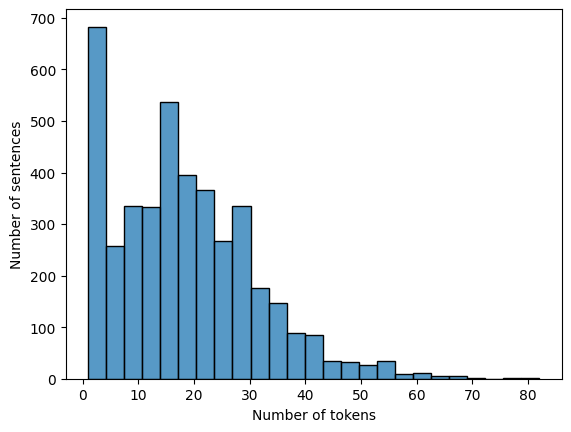

In [30]:
## Size of sentences
sents: list[dict] = [{
    "sentence": d.sentence,
    "num_of_tokens": len(nltk.word_tokenize(d.sentence))
} for d in training_dataset]

largest_sent = reduce(lambda max, s: s if max.get("num_of_tokens") < s.get("num_of_tokens") else max, sents)
smallest_sent = reduce(lambda min, s: s if min.get("num_of_tokens") > s.get("num_of_tokens") else min, sents)
print("Sentence with largest number of tokens:")
print(largest_sent) # “ Apple đã tập trung vào việc nâng cao đáng kể Chất lượng hình ảnh tuyệt đối và Độ chính xác màu sắc tuyệt đối của màn hình OLED bằng cách thực hiện hiệu chỉnh màn hình chính xác tại nhà máy , nâng hiệu suất hiển thị tổng thể của iPhone 12 Pro Max lên đến mức độ vượt trội , độ chính xác hoàn hảo đến mức không thể phân biệt bằng mắt thường ” , DisplayMate đánh giá .
print("Sentence with smallest number of tokens:")
print(smallest_sent) # Pin

sents = pd.Series([s.get("num_of_tokens") for s in sents])
print(reduce(lambda acc, s: acc + 1 if s <= 3 else acc, sents.tolist()))
sbn.histplot(sents, bins=25)
plt.xlabel("Number of tokens")
plt.ylabel("Number of sentences")
plt.show()

##### a. Check if any sentence is duplicated

**Conclusion 1**: All duplicate sentences need to be removed.

Suggested command: ``train_df.loc[train_df.sentence.drop_duplicates().index.tolist()]``

In [261]:
""" Check if any sentence is duplicated """
train_df = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))
print(f"Original size of training set: {len(train_df)}")

dups = train_df[train_df.sentence.duplicated()]
print(f"Number of duplicates: {len(dups)}")

dups_with_quin = dups[dups.quintuples.notna()]
print(f"Duplicates where at least 1 quintuple exists: {len(dups_with_quin)} sentences in total.")

# for i in range(len(dups_with_quin)):
#   print(f"Tuple {i + 1}:")
#   print(train_df[train_df.sentence.str.contains(dups_with_quin.iloc[i].sentence)])

train_df = train_df.loc[train_df.sentence.drop_duplicates().index.tolist()] # remove duplicates
print(f"Size of training set after modified: {len(train_df)}")

Original size of training set: 4171
Number of duplicates: 659
Duplicates where at least 1 quintuple exists: 4 sentences in total.
Size of training set after modified: 3512


##### b. Special sentences
- **Conclusion 2**: '(alt : )|(des : )|(title : )' does not contribute any meaning to a sentence, thus they should be filtered out before processing.
- **Conclusion 3**: There's no sentence that has at least 1 quintuple & contains '?'. These sentences containing '?' need to be removed.
- **Conclusion 4**: The sentences "starting with 'des : ', 'alt : ' & having at least 1 quin" need to be kept.
- **Conclusion 5**: after removing 'des : ', 'alt : ', the result sentences may have been existed in the original training dataset (there're 166 duplicates in total)
=> Continue removing duplicates by the recommended command above.

In [262]:
"""
In this section (and maybe others), we define a special sentence is a sentence containing either of "alt", "des", "title" or "?"
Examine if a sentence containing "(alt : )|(des : )|(title : )|(\?)" can have quintuple or not.
Note that all duplicate sentences will be filtered out before examining.
"""
train_df = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))
train_df = train_df.loc[train_df.sentence.drop_duplicates().index.tolist()] # remove duplicates for the 1st time

questions_and_titles = train_df[train_df.sentence.str.contains("(\?)|(title)")]
special_sentences = train_df[train_df.sentence.str.contains("(alt)|(des)")]
print()

## Questions & titles
# print(len(train_df[train_df.sentence.str.contains("title")]))
# print(len(train_df[train_df.sentence.str.contains("\?")]))
print(f"Sentences containing '?' and/or 'title : ' ({len(questions_and_titles)}) and having quintuple:", end=" ")
print(len(questions_and_titles[questions_and_titles.quintuples.notnull()]))
# print(special_sentences[special_sentences.sentence.str.contains("(title)", regex=True)])
print("=> Conclusion 3: There's no sentence satisfy the 2 conditions above. These sentences containing '?' and/or 'title : ' need to be removed.\n")

# Remove questions and titles
train_df.drop(questions_and_titles.index.tolist(), inplace=True)

## Special sentences
print(f"Number of special sentences starting with 'des : ', 'alt : ': {len(special_sentences)}")  # before removing: 1043; after: 592
# print(f"where number of dups: {len(special_sentences[special_sentences.sentence.duplicated()])}") # before removing: 451; after: 0

## Special sentences with quintuple
special_sentences_with_quin = special_sentences[special_sentences.quintuples.notna()]
print(f"Number of special sentences (starting with 'des : ', 'alt : ') having at least 1 quin: {len(special_sentences_with_quin)}")
print("=> Conclusion 4: Those sentences need to be kept.\n")

print(f"Dups before removing 'des : ' & 'alt : ':: {len(train_df[train_df.sentence.duplicated()])}")

# Substitute "(des : )|(alt : )" with "" and replace old strings with those in train_df
for i in range(len(special_sentences)):
  new_sent = re.sub("(des : )|(alt : )", "", special_sentences.iloc[i].sentence)
  train_df.sentence.replace(special_sentences.iloc[i].sentence, new_sent, inplace=True)

  # if len(train_df[train_df.sentence == new_sent]) > 0:
  #   print(f"Tuple {i}:")
  #   print(f"Original:\n{special_sentences.iloc[i]}")
  #   print(f"Dup:\n{train_df[train_df.sentence == new_sent]}\n")

tmp = len(train_df[train_df.sentence.duplicated()])
print(f"Dups after removing 'des' & 'alt': {tmp}")
print(f"""
Conclusion 5: after removing 'des : ', 'alt : ', the result sentences may have
been existed in the original training dataset (there're {tmp} duplicates in total)"""
)

# new_dups = train_df[train_df.sentence.duplicated()]
# for i in range(len(new_dups)):
#   print(f"Tuple {i}:")
#   print(train_df[train_df.sentence == new_dups.iloc[i].sentence], end="\n")

# uncomment the code above to print all tuples
print("""
After observing all the duplicates, we can conclude that in each duplicate tuple,
all members are completely the same.
So, we can delete them by reusing the recommended command (conclusion 1)."""
)

train_df = train_df.loc[train_df.sentence.drop_duplicates().index.tolist()] #

# print(f"\nDups after being removed for the 2nd time: {len(train_df[train_df.sentence.duplicated()])} (test)")
print(f"\nSize of training set after modified: {len(train_df)}")

<ipython-input-262-10d77a1b6708>:9: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  questions_and_titles = train_df[train_df.sentence.str.contains("(\?)|(title)")]
<ipython-input-262-10d77a1b6708>:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  special_sentences = train_df[train_df.sentence.str.contains("(alt)|(des)")]



Sentences containing '?' and/or 'title : ' (131) and having quintuple: 0
=> Conclusion 3: There's no sentence satisfy the 2 conditions above. These sentences containing '?' and/or 'title : ' need to be removed.

Number of special sentences starting with 'des : ', 'alt : ': 548
Number of special sentences (starting with 'des : ', 'alt : ') having at least 1 quin: 24
=> Conclusion 4: Those sentences need to be kept.

Dups before removing 'des : ' & 'alt : ':: 0
Dups after removing 'des' & 'alt': 165

Conclusion 5: after removing 'des : ', 'alt : ', the result sentences may have 
been existed in the original training dataset (there're 165 duplicates in total)

After observing all the duplicates, we can conclude that in each duplicate tuple, 
all members are completely the same.
So, we can delete them by reusing the recommended command (conclusion 1).

Size of training set after modified: 3216


##### c. Examine sizes of the training sentences

Note that you should run the previous block to remove redundant sentences/sequences.

**Conclusion 6**: Most of "short" sentences does not contain quintuple. Specifically, we can remove all sentences with 0-3 tokens and consider to remove sentences with 4-7 tokens (but the sentences with quintuple should be kept).


- Sentences with ...
(Pattern: `<total of sentences> - <sentences contain quintuple>`)
  - 0-3 tokens: 163 - 0
  - 4 tokens: 54 - 1
  - 5 tokens: 51 - 2
  - 6 tokens: 55 - 3
  - 7 tokens: 78 - 3
  - 8 tokens: 74 - 7

    ...

In [ ]:
""" Examine sizes of the training sentences """
MINIMUM_NUM_OF_TOKENS = 7
# train_df = pd.DataFrame(DatasetUtils.to_multi_quintuples_dict_list(training_dataset))
print(f"Size of training set before modified: {len(train_df)}\n")

for min_t in range(MINIMUM_NUM_OF_TOKENS + 1):

  short_sentences = train_df.loc[[item[0] for item in train_df.sentence.items() if len(nltk.word_tokenize(item[1])) <= min_t]]
  short_sentence_indexes_with_quin = [i for i, row in short_sentences.iterrows() if not row.quintuples is None]

  print(f"Given minimum number of tokens is {min_t}.")
  print(f"Number of short sentences: {len(short_sentences)}")
  print(f"Number of short sentences with quin: {len(short_sentence_indexes_with_quin)}")

  ## demo the process of removing short sentences
  short_sentences.drop(short_sentence_indexes_with_quin, inplace=True)
  # print(f"Number of short sentences (after modified): {len(short_sentences)}") # validate
  train_df.drop(short_sentences.index.tolist(), inplace=True)
  # print(f"training size: {len(train_df)}") # validate
  print()

# for i, row in short_sentences.iterrows():
#   if not row.quintuples is None:
#     print(row)

print(f"Size of training set after modified: {len(train_df)}\n")

##### d. Others
- Presences of numbers in the first positions of a sentence are redandunt or not?

#### 4. Analyzing quintuple's fields

Note: may need to validate word's indexes in quintuples

##### a. subject

###### General reviews

- A subject can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro"...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới"...
  - a phrase showing (owning) relationship between 2 nouns: "điện thoại đắt tiền hơn của Apple", "Các bức ảnh chụp với S20", "Màn hình của Redmi Note 11 Pro +", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 3 chiếc máy", ...
  - more complicated form: "các cổng kết nối cùng nút bấm", "Màn hình đục lỗ không khống chế ở góc màn hình mà lại là chính giữa", "Chip A15 Bionic cung cấp hiệu năng khủng cho iPhone 13", ...
- There're some presences of miss spelling ("ấn tượn" -> "ấn tượng"), lack of spaces ("SEmới) ... This typing errors are trivial & quite rare.

  ⇒ should be corrected.

- Length: 1-16,
  - The distribution is mainly in range 1-6.
  - Subjects with length 9-16 rarely exist.
- Presences of non-word characters ('+', '-', ',', '.', '/', etc):

  ...

- Total of blank subjects / All quintuples: 128/1089
- Total of non-blank unique subjects / Non-blank subjects: 427/961

Longest:
  {'subject': 'Màn hình đục lỗ không khống chế ở góc màn hình mà lại là chính giữa', 'tokens': ['Màn', 'hình', 'đục', 'lỗ', 'không', 'khống', 'chế', 'ở', 'góc', 'màn', 'hình', 'mà', 'lại', 'là', 'chính', 'giữa'], 'length': 16}
Shortest:
  {'subject': 'Xiaomi', 'tokens': ['Xiaomi'], 'length': 1}


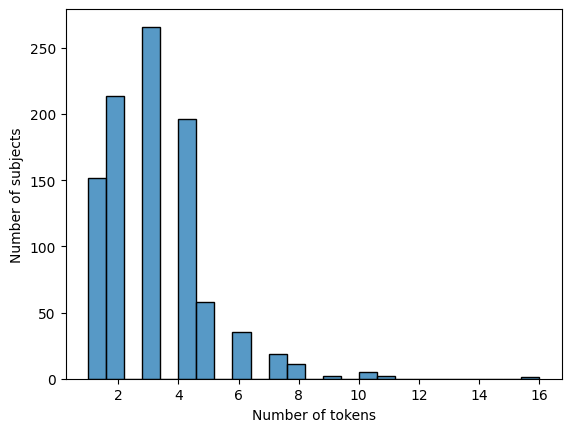

In [240]:
## Initialize dataset ##
flattened_df = pd.DataFrame(flattened_train_dataset)
####

blank_counter = len(flattened_df[flattened_df.subject.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank subjects / All quintuples: {blank_counter}/{TOTAL_QUINTUPLES}")

df = flattened_df[flattened_df.subject.str.contains("^.{1,}$", na=False)]

subjects = df.subject
unique_subjects = df.subject.unique().tolist()

print(f"- Total of non-blank unique subjects / Non-blank subjects: {len(unique_subjects)}/{len(subjects)}")
print()

tokenized_subjects = []

for s in subjects:
  tokens = nltk.word_tokenize(s)
  tokenized_subjects.append({
      "subject": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_subject = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_subjects)
shortest_subject = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_subjects)

print(f"Longest:\n  {longest_subject}")
print(f"Shortest:\n  {shortest_subject}")

subjects_lengths: list[int] = [s.get("length") for s in tokenized_subjects]

sbn.histplot(pd.Series(subjects_lengths), bins=25)
plt.xlabel("Number of tokens")
plt.ylabel("Number of subjects")
plt.show()

###### BoW & Wordcloud

Conclusions:
- "samsung", "galaxy", "điện", "thoại" ... are some of the most popular words in subjects. => most of datasets come from 'electronic device reviews', especially in topics about 'cellphone', 'camera'.

- Some tuples of words usually stand together, for example:
  - "điện thoại", "sản phẩm", "thiết bị", "xử lý" ... All of these are Vietnamese compound words.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" always goes with at least 1 token to indicate a model name or product line.

  - "cả" always goes with other words. in "Cả 2", "cả hai", "cả 3".

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "chiếc" - 29,

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [355]:
nonblank_subjects = flattened_df[flattened_df.subject.str.contains("^.{1,}$", na=False)].subject

In [356]:
""" Bag-of-Words """
subject_bow: dict[str, int] = make_BoW(nonblank_subjects)
print(subject_bow)
print(f"Size of BoW: {len(subject_bow)}")

{'galaxy': 234, 'ultra': 127, 'samsung': 125, 'pro': 103, 'iphone': 100, 'hai': 89, 'cả': 87, 'điện': 72, 'thoại': 72, 's23': 53, '2': 44, 'này': 43, 'nó': 42, 'máy': 42, 'note': 35, '11': 35, 's22': 35, '5g': 34, 'của': 34, 'xiaomi': 33, 'max': 32, '13': 32, 'chiếc': 29, 'z': 29, 'dòng': 28, 'camera': 27, 's21': 27, 'oppo': 23, 'hình': 23, 'plus': 22, '12': 20, 'điện': 19, 'thoại': 19, '+': 19, 's20': 19, 'find': 18, 'smartphone': 18, 'flip': 18, '14': 17, 'trên': 17, 'redmi': 17, 'mẫu': 16, 'snapdragon': 16, 'màn': 16, 'đây': 16, 'a51': 16, 'ảnh': 15, 'pixel': 15, 'apple': 13, 'a53': 13, 'cả': 12, 'các': 12, '8': 12, 'a73': 12, '20': 12, 'realme': 12, 'mới': 11, 'se': 11, 'sản': 11, 'phẩm': 11, 'mi': 11, 's10': 11, 'm51': 11, '7': 11, 'n2': 11, 'phiên': 10, 'chip': 10, 'thiết': 10, 'a13': 10, 'bản': 10, '4': 10, 'a32': 10, 'a52s': 10, 'a23': 10, 'thiết': 9, 'bị': 9, 'fold2': 9, 'rog': 9, 'phone': 9, 'với': 9, 'flagship': 8, 'di': 8, 'động': 8, 'bộ': 8, 'bị': 8, 'fold': 8, 'xử': 

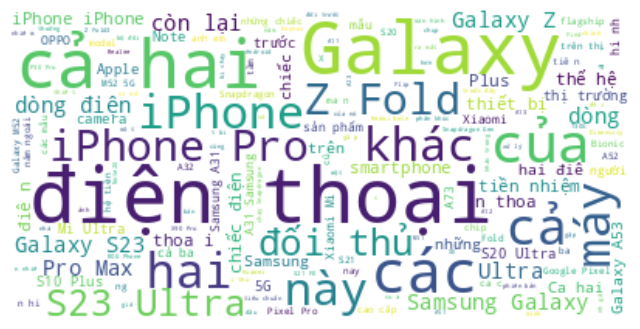

In [357]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist(), stopwords=[],
                 max_font_size=50, max_words=350, background_color="white")

In [238]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ -
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
filt = [s for s in nonblank_subjects if re.match(".{0,}chiếc.{0,}", s.lower())]
len(filt)

29

##### b. object

###### General reviews

- An object can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro", "A73", ...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 2", "cả hai", ...
  - a phrase showing (owning) relationship between 2 nouns: "tổ hợp zoom 3X + 10X trên Galaxy", 'những chiếc máy khác sử dụng " thuật toán AI "',...
  - more complicated form: "các cổng kết nối cùng nút bấm", "các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi", "ống kính full-frame f / 6.5", ...

- An object may be placed before subject in a sentence. E.g. "Cả 2", ...
- Length: 1-17
  - The distribution is mainly in range 1-6. (number?)
  - Subjects with length 12-17 rarely exist. (number?)
- Presences of non-word characters:
    ...

- Total of blank objects / All quintuples: 468/1089
- Total non-blank unique object / Non-blank objects: 355/621
Longest:
  {'object': 'các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi', 'tokens': ['các', 'màn', 'hình', 'có', 'tốc', 'độ', 'làm', 'mới', '90', 'Hz', 'hay', '120', 'Hz', 'của', 'Realme', 'hoặc', 'Xiaomi'], 'length': 17}
Shortest:
  {'object': 'Galaxy', 'tokens': ['Galaxy'], 'length': 1}



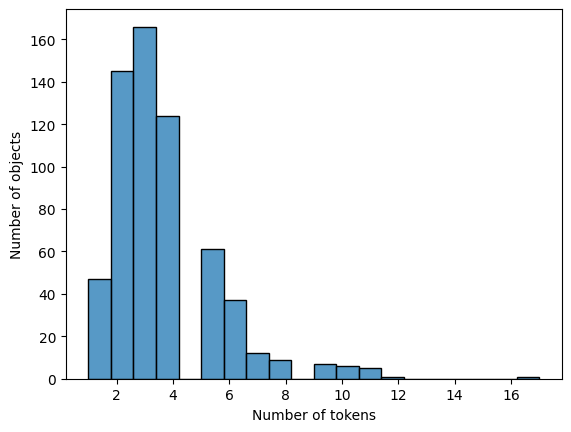

In [239]:
## Initialize dataset ##
flattened_df = pd.DataFrame(flattened_train_dataset)
####

blank_counter = len(flattened_df[flattened_df.object.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank objects / All quintuples: {blank_counter}/{TOTAL_QUINTUPLES}")

# Filter out blank strings
df = flattened_df[flattened_df.object.str.contains("^.{1,}$", na=False)]

objects = df.object
unique_objects = objects.unique().tolist()

print(f"- Total non-blank unique object / Non-blank objects: {len(unique_objects)}/{len(objects)}")

tokenized_objects = []

for s in objects:
  tokens = nltk.word_tokenize(s)
  tokenized_objects.append({
      "object": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_object = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_objects)
shortest_object = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_objects)

print(f"Longest:\n  {longest_object}")
print(f"Shortest:\n  {shortest_object}\n")

objects_lengths: list[int] = [s.get("length") for s in tokenized_objects]

sbn.histplot(pd.Series(objects_lengths), bins=20)
plt.xlabel("Number of tokens")
plt.ylabel("Number of objects")
plt.show()

###### BoW & Wordcloud

Conclusions:
- "samsung", "galaxy", "điện", "thoại", "cả" ... are some of the most popular words in objects.

- Some tuples of words usually stand together, for example:
  - "điện thoại", "sản phẩm", "thiết bị", "xử lý", "thế hệ", "tiền nhiệm" ... All of these are Vietnamese compound words; member words always stand together.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" *almost* goes with at least 1 token to indicate a model name or product line.

  - "cả" always goes with other words. in "Cả 2", "cả hai", "cả 3".

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "là" - 1, "chiếc" - 25,

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [350]:
# Execute this first
nonblank_values = flattened_df[flattened_df.object.str.contains("^.{1,}$", na=False)].object

In [352]:
""" Bag-of-Words """
object_bow: dict[str, int] = make_BoW(nonblank_values)
print([i for i in object_bow.items() if i[1] < 3])
print(f"Size of BoW: {len(object_bow)}")

[('a03s', 2), ('vivo', 2), ('dòng', 2), ('m1', 2), ('ipad', 2), ('``', 2), ('chúng', 2), ('chipset', 2), ('a14', 2), ('xs', 2), ('số', 2), ('tất', 2), ('s10e', 2), ('hiện', 2), ('s22', 2), ('người', 2), ('mình', 2), ('bản', 2), ('thông', 2), ('ghz', 2), ('a16', 2), ('hùng', 2), ('mạnh', 2), ('hệ', 2), ('inch', 2), ('điểm', 2), ('kế', 2), ('20', 2), ('mặt', 2), ('m32', 2), ('đại', 2), ('diện', 2), ('khả', 2), ('năng', 2), ('đêm', 2), ('mediatek', 2), ('a74', 2), ('mini', 2), ('ngày', 2), ('hôm', 2), ('a52s', 2), ('con', 2), ('9000', 2), ('ống', 2), ('kính', 2), ('full-frame', 2), ('f', 2), ('a57', 2), ('đó', 2), ('adreno', 2), ('mới', 2), ('hz', 2), ('hay', 2), ('5', 2), (',', 2), ('trung', 2), ('9', 2), ('micro-usb', 2), ('ips', 2), ('hàng', 2), ('n2', 2), ('bình', 2), ('nào', 1), ('y21', 1), ('sản', 1), ('phẩm', 1), ('thuộc', 1), ('này', 1), ('tổ', 1), ('hợp', 1), ('zoom', 1), ('3x', 1), ('10x', 1), ('mọi', 1), ('sử', 1), ('dụng', 1), ('thuật', 1), ('toán', 1), ('ai', 1), ('x

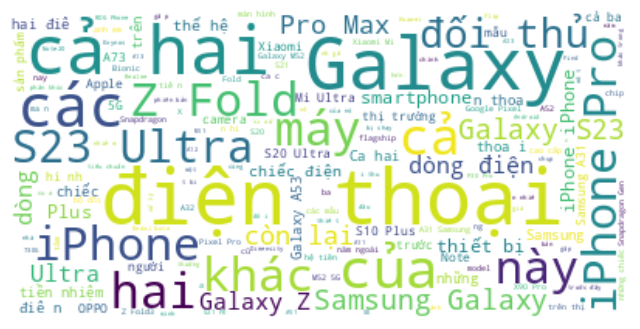

In [351]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist(), stopwords=[],
                 max_font_size=50, max_words=350, background_color="white")

In [272]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ - \" (1)
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
# considered words: có đi với đang "có mặt"
filt = [s for s in nonblank_values if re.match(".{0,}thoại.{0,}", s.lower())]
filt

['chiếc điện thoại nào trên thị trường',
 'Cả hai điện thoại',
 'Cả hai điện thoại',
 'dòng điện thoại này',
 'các dòng điện thoại khác',
 'các dòng điện thoại khác',
 'các điện thoại còn lại',
 'cả 2 dòng điện thoại',
 '2 dòng điện thoại này',
 'cả 2 dòng điện thoại này',
 'cả 2 dòng điện thoại này',
 'cả 3 điện thoại của dòng iPhone 11',
 'Đa số các dòng điện thoại',
 'Cả 2 dòng điện thoại',
 'tất cả các dòng điện thoại về sau của Apple',
 'cả 2 chiếc điện thoại này',
 'cả 2 chiếc điện thoại này',
 'Cả 2 điện thoại',
 'camera trước của điện thoại màn hình gập',
 'hai điện thoại còn lại',
 'hai điện thoại còn lại',
 'hai điện thoại còn lại',
 'cả hai điện thoại',
 'cả hai điện thoại',
 'cả hai điện thoại',
 'cả hai điện thoại',
 'Cả hai điện thoại',
 'Hai điện thoại',
 'bộ đôi điện thoại',
 'bộ đôi điện thoại',
 'bộ đôi điện thoại',
 'cả ba điện thoại',
 'bộ ba điện thoại ngày hôm nay',
 'cả hai điện thoại',
 'Cả 2 chiếc điện thoại',
 'Cả 2 chiếc điện thoại',
 'các điện thoại khác 

##### c. aspect

###### General reviews *(not modified yet)*

- An aspect can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro", "A73", ...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 2", "cả hai", ...
  - a phrase showing (owning) relationship between 2 nouns: "tổ hợp zoom 3X + 10X trên Galaxy", 'những chiếc máy khác sử dụng " thuật toán AI "',...
  - more complicated form: "các cổng kết nối cùng nút bấm", "các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi", "ống kính full-frame f / 6.5", ...

- An aspect may be placed before subject in a sentence. E.g. "Cả 2", ...
- Length: 1-17
  - The distribution is mainly in range 1-6. (number?)
  - Subjects with length 12-17 rarely exist. (number?)
- Presences of non-word characters:
    ...

- Total of blank aspects / All quintuples: 154/1089
- Total non-blank unique aspect / Non-blank aspects: 564/935
Longest:
  {'aspect': 'khả năng tái tạo màu sắc chính xác và ổn định trong hầu hết mọi điều kiện', 'tokens': ['khả', 'năng', 'tái', 'tạo', 'màu', 'sắc', 'chính', 'xác', 'và', 'ổn', 'định', 'trong', 'hầu', 'hết', 'mọi', 'điều', 'kiện'], 'length': 17}
Shortest:
  {'aspect': 'giá', 'tokens': ['giá'], 'length': 1}



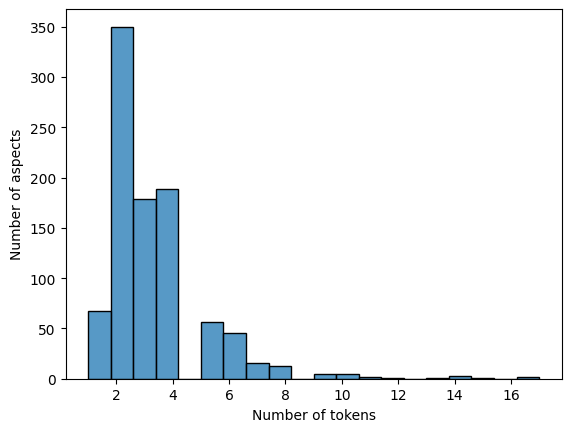

In [243]:
## Initialize dataset ##
flattened_df = pd.DataFrame(flattened_train_dataset)
####

blank_counter = len(flattened_df[flattened_df.aspect.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank aspects / All quintuples: {blank_counter}/{TOTAL_QUINTUPLES}")

# Filter out blank strings
df = flattened_df[flattened_df.aspect.str.contains("^.{1,}$", na=False)]

aspects = df.aspect
unique_aspects = aspects.unique().tolist()

print(f"- Total non-blank unique aspect / Non-blank aspects: {len(unique_aspects)}/{len(df)}")

tokenized_aspects = []

for s in aspects:
  tokens = nltk.word_tokenize(s)
  tokenized_aspects.append({
      "aspect": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_aspect = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_aspects)
shortest_aspect = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_aspects)

print(f"Longest:\n  {longest_aspect}")
print(f"Shortest:\n  {shortest_aspect}\n")

aspects_lengths: list[int] = [s.get("length") for s in tokenized_aspects]

sbn.histplot(pd.Series(aspects_lengths), bins=20)
plt.xlabel("Number of tokens")
plt.ylabel("Number of aspects")
plt.show()

###### BoW & Wordcloud *(not modified yet)*

Conclusions:
- "samsung", "galaxy", "điện", "thoại" ... are some of the most popular words in aspects.

- Some tuples of words usually stand together, for example:
  - "điện thoại", "sản phẩm", "thiết bị", "xử lý", "tiền nhiệm", "thế hệ", "thị trường" ... All of these are Vietnamese compound words.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" *almost* goes with at least 1 token to indicate a model name or product line.

  - "cả" always goes with other words. in "Cả 2", "cả hai", "cả 3".

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "là" - 1, "chiếc" - 25,

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [347]:
# Execute this first
nonblank_values = flattened_df[flattened_df.aspect.str.contains("^.{1,}$", na=False)].aspect

In [348]:
""" Bag-of-Words """
aspect_bow: dict[str, int] = make_BoW(nonblank_values)
print([i for i in aspect_bow.items() if i[1] > 6])
print(f"Size of BoW: {len(aspect_bow)}")

[('hình', 118), ('năng', 94), ('lượng', 80), ('độ', 76), ('màn', 75), ('ảnh', 73), ('camera', 69), ('pin', 63), ('khả', 45), ('chụp', 41), ('chất', 39), ('hiệu', 36), ('kế', 35), ('thiết', 34), ('sạc', 32), ('số', 30), ('mức', 27), ('các', 25), ('kích', 24), ('giá', 24), ('dung', 24), ('bộ', 24), ('thước', 23), ('giải', 22), ('phần', 22), ('phân', 22), ('cảm', 20), ('mặt', 20), ('màu', 19), ('biến', 18), ('sáng', 18), ('tiết', 18), ('thời', 18), ('thông', 17), ('lý', 17), ('chính', 16), ('hình', 16), ('điểm', 16), ('hiển', 16), ('thị', 16), ('tốc', 16), ('xử', 16), ('sắc', 15), ('sau', 14), ('không', 14), ('đa', 14), ('chi', 13), ('và', 12), ('trong', 12), ('công', 12), ('chip', 12), ('động', 12), ('trước', 11), ('mới', 11), ('suất', 11), ('máy', 11), ('lượng', 11), ('cấu', 11), ('tính', 11), ('cụm', 11), ('định', 10), ('selfie', 10), ('màn', 10), ('dây', 10), ('này', 10), ('cứng', 10), ('kính', 10), ('những', 10), ('tối', 10), ('nhanh', 10), ('làm', 10), ('ổn', 9), ('hệ', 9), ('ngh

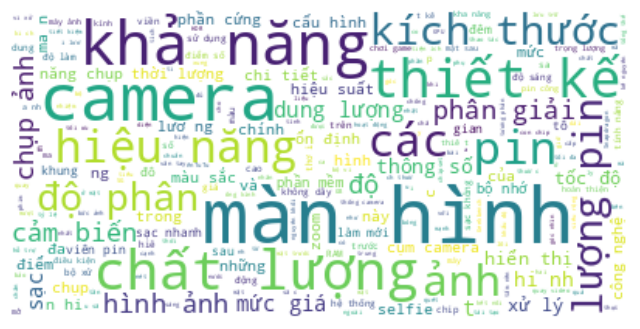

In [349]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist(), stopwords=[],
                 max_font_size=50, max_words=350, background_color="white")

In [ ]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ - \" (1)
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
# considered words: có đi với đang "có mặt"
filt = [s for s in nonblank_values if re.match(".{0,}hệ.{0,}", s.lower())]
filt

##### d. predicate

###### General reviews *(not modified yet)*

- A predicate can be:
  - a product name only: "iPhone 12", "iPhone 12 Pro", "A73", ...
  - a (phrasal) noun: "hai thiết bị", "ảnh", "Mỗi thế hệ iPhone mới", ...
  - a (phrasal) noun that refers to products mentioned right before it: "Cả 2", "cả hai", ...
  - a phrase showing (owning) relationship between 2 nouns: "tổ hợp zoom 3X + 10X trên Galaxy", 'những chiếc máy khác sử dụng " thuật toán AI "',...
  - more complicated form: "các cổng kết nối cùng nút bấm", "các màn hình có tốc độ làm mới 90 Hz hay 120 Hz của Realme hoặc Xiaomi", "ống kính full-frame f / 6.5", ...

- A predicate may be placed before subject in a sentence. E.g. "Cả 2", ...
- Length: 1-17
  - The distribution is mainly in range 1-6. (number?)
  - Subjects with length 12-17 rarely exist. (number?)
- Presences of non-word characters:
    ...

- Total of blank predicates / All quintuples: 0/1089
- Total non-blank unique predicate / Non-blank predicates: 630/1089
Longest:
  {'predicate': 'đều được sử dụng chip Snapdragon 8 Gen 2 mới nhất của Qualcomm với các lõi được ép xung', 'tokens': ['đều', 'được', 'sử', 'dụng', 'chip', 'Snapdragon', '8', 'Gen', '2', 'mới', 'nhất', 'của', 'Qualcomm', 'với', 'các', 'lõi', 'được', 'ép', 'xung'], 'length': 19}
Shortest:
  {'predicate': 'thiếu', 'tokens': ['thiếu'], 'length': 1}



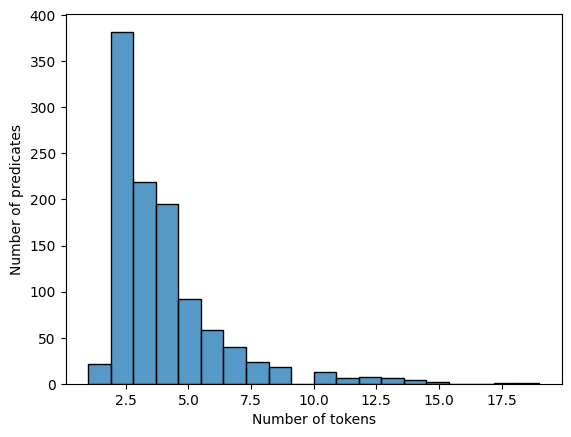

In [281]:
## Initialize dataset ##
flattened_df = pd.DataFrame(flattened_train_dataset)
####

blank_counter = len(flattened_df[flattened_df.predicate.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank predicates / All quintuples: {blank_counter}/{TOTAL_QUINTUPLES}")

# Filter out blank strings
df = flattened_df[flattened_df.predicate.str.contains("^.{1,}$", na=False)]

predicates = df.predicate
unique_predicates = predicates.unique().tolist()

print(f"- Total non-blank unique predicate / Non-blank predicates: {len(unique_predicates)}/{len(df)}")

tokenized_predicates = []

for s in predicates:
  tokens = nltk.word_tokenize(s)
  tokenized_predicates.append({
      "predicate": s,
      "tokens": tokens,
      "length": len(tokens)
  })

longest_predicate = reduce(lambda longest, s: s if s.get("length") > longest.get("length") else longest, tokenized_predicates)
shortest_predicate = reduce(lambda shortest, s: s if s.get("length") < shortest.get("length") else shortest, tokenized_predicates)

print(f"Longest:\n  {longest_predicate}")
print(f"Shortest:\n  {shortest_predicate}\n")

predicates_lengths: list[int] = [s.get("length") for s in tokenized_predicates]

sbn.histplot(pd.Series(predicates_lengths), bins=20)
plt.xlabel("Number of tokens")
plt.ylabel("Number of predicates")
plt.show()

###### BoW & Wordcloud *(not modified yet)*

Conclusions:
- "so với", "so sánh", "hơn", "chút", "tốt", "nhất", "không" ... are some of the most popular words in predicates.

- Some tuples of words usually stand together, for example:
  - "một chút", "mạnh mẽ", "", "chi tiết", "tiết kiệm", "thế hệ", "thị trường", "xử lý", "tương đồng", "tương tự", "màu sắc", "sắc nét", "sử dụng", "hiện nay", "hiện tại", ... All of these are Vietnamese compound words.

  - "[Samsung] Galaxy [product-line or model-name]": the word "Galaxy" *almost* goes with at least 1 token to indicate a model name or product line.

  ⇒ Candidates for segmentation.

- Stopword candidates: "này" - 43, "đây" - 16, "là" - 1, "chiếc" - 25, "cả" - 2

- Non-word characters:
  - Should not remove `',', '.', '/', '+'` although they're minor. The reason is these characters may contribute to a number or product model name.

In [341]:
# Execute this first
nonblank_values = flattened_df[flattened_df.predicate.str.contains("^.{1,}$", na=False)].predicate

In [345]:
""" Bag-of-Words """
predicate_bow: dict[str, int] = make_BoW(nonblank_values)
print([i for i in predicate_bow.items() if i[1] > 3])
print(f"Size of BoW: {len(predicate_bow)}") # largest in the 4 fields of quin

[('hơn', 501), ('tốt', 117), ('đều', 109), ('nhất', 105), ('có', 89), ('không', 82), ('cao', 74), ('nhiều', 71), ('như', 47), ('khác', 45), ('được', 44), ('tương', 44), ('vượt', 43), ('một', 39), ('trội', 38), ('biệt', 38), ('cấp', 36), ('lớn', 36), ('nay', 35), ('mạnh', 31), ('hiện', 31), ('nhau', 30), ('sự', 30), ('chút', 30), ('thế', 28), ('rất', 26), ('nhỉnh', 25), ('nhanh', 25), ('và', 25), ('giống', 23), ('bị', 23), ('trên', 21), ('trong', 21), ('thấp', 21), ('khá', 20), ('là', 19), ('ngang', 19), ('kém', 19), ('chi', 19), ('đều', 18), ('mẽ', 18), ('với', 18), ('trang', 18), ('nâng', 17), ('gần', 17), ('tiết', 17), ('sở', 17), ('của', 17), ('nhỏ', 16), ('so', 16), ('thể', 15), ('đáng', 15), ('lượng', 15), ('hữu', 15), ('cải', 15), ('đương', 15), ('chênh', 14), ('về', 13), ('thị', 13), ('nhẹ', 13), ('đồng', 13), ('phân', 13), ('tiến', 13), ('được', 12), ('dụng', 12), ('cùng', 12), ('sáng', 12), ('lợi', 12), ('rẻ', 12), ('phần', 11), ('trường', 11), ('smartphone', 11), ('bằng', 1

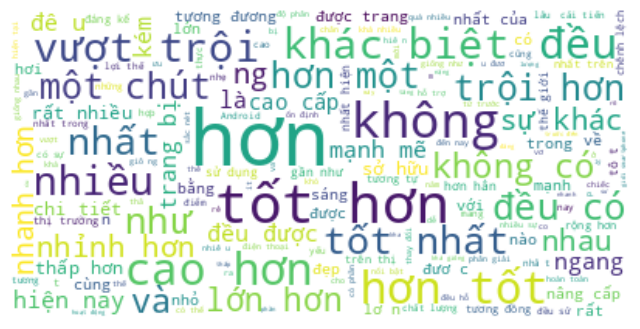

In [343]:
""" Wordcloud """
"Basis of decisions to (1) remove stopwords, special characters & (2) word segmentation"
render_wordcloud(nonblank_values.tolist())

In [388]:
""" Examine several single words or characters manually """
# Put word or character between 2 '.{0,}'. For example: ".{0,}xiao.{0,}"
# List of recommended non-word characters: \\. , / \\+ - \" (1)
# List of words: depend on bag of words & wordcloud; note that the word must be lowercase.
# considered words: có đi với đang "có mặt"
# filt = [s for s in nonblank_values if re.match(".{0,}hiện.{0,}", s.lower())]
print("Predicates with 'DIF':")
print(flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}.{0,}", str(v).lower())]].query("label == 'DIF'").predicate.unique())
print("\nPredicates with other:")
print(flattened_df.loc[[i for i, v in flattened_df.predicate.items() if re.match(".{0,}(khác)|(chênh).{0,}", str(v).lower())]].query("label == 'EQL'").predicate.unique())
# filt

Predicates with 'DIF':
['hiếm có chiếc điện thoại nào trên thị trường có thể làm được' 'thiếu'
 'ngược lại' 'khác biệt dễ nhận thấy' 'không hoàn toàn ngang bằng'
 'chênh lệch rõ ràng' 'không có' 'lột xác hoàn toàn'
 'không bị ngả sang tone vàng như' 'không bị bệt hay mất chi tiết như'
 'sự thay đổi đáng kể' 'khác biệt'
 'một trong những điểm khác biệt dễ thấy nhất' 'sự khác biệt đáng kể'
 'không còn như xưa' 'không đều'
 'không có khả năng sạc nhanh vượt trội như' 'khác biệt rõ ràng'
 'không giống như' 'Khác biệt' 'điểm khác biệt lớn nhất' 'rất khác nhau'
 'khác biệt đáng kể' 'Khác' 'có một khoảng cách' 'thay đổi' 'khác biệt'
 'không hề có một chiếc tai thỏ nào' 'Không sở hữu sự tương đồng'
 'Điểm khác biệt' 'nhiều sự khác biệt hơn thế' 'sự khác nhau'
 'Điểm khác biệt lớn nhất' 'không được xử lý như' 'hơi lạ'
 'hơi dịch lên phía trên một chút' 'có sự khác biệt' 'khác nhau'
 'sự khác biệt rõ ràng nhất' 'có sự chênh lệch khá lớn'
 'không có tính năng tương tự' 'không có 

##### e. label

Do labels relate to the existences of remaining fields?

List some following information of the 4 remaining fields for each label type:
- predicate: most popular words (may render cloudword)
- subject & object: most popular (compound) words
- frequencies of existences of the 3 fields (subject, object, aspect)

###### Init & creating helper functions

In [ ]:
## Initialize dataset ##
flattened_df = pd.DataFrame(flattened_train_dataset)
####

blank_counter = len(flattened_df[flattened_df.label.str.contains("^\s{0,}$", na=False)])

print(f"- Total of blank labels / All quintuples: {blank_counter}/{TOTAL_QUINTUPLES}")

labels = flattened_df[flattened_df.label.str.contains("^.{1,}$", na=False)].label.unique().tolist()

In [336]:
def calc_BoW(field: str, label: str, df: pd.DataFrame = flattened_df):
  allowed_fields = ["subject", "object", "aspect", "predicate"]

  assert field in allowed_fields, (
      f"Input field must be one of {allowed_fields}"
  )
  assert label in labels, f"Label must be one of {labels}"

  return make_BoW(df[df.label == label][field])

def calc_frequency(field: str, label: str, df: pd.DataFrame = flattened_df):
  allowed_fields = ["subject", "object", "aspect"]

  assert field in allowed_fields, (
      f"Input field must be one of {allowed_fields}"
  )
  assert label in labels, f"Label must be one of {labels}"


  df_l = df[df.label == label]
  df_f = df_l[df_l[field].str.contains("^.{1,}$", na=False)]

  return len(df_f)

# Test
# calc_frequency("subject", "SUP")

###### i. Counting quintuples & sentences on each type of label
Main function: `relate_labels_with_others(flattened_df: pd.DataFrame)`

Present num_of_data_points (number of quintuples) and num_of_sentences on each label type:
(group 'SUP-' and 'SUP')
        label  num_of_data_points  num_of_sentences
0        COM+                 500               371
1         EQL                 287               249
2        SUP+                 107                87
3        COM-                 107                86
4         DIF                  58                52
5         COM                  21                19
6  SUP- & SUP                   9                 8



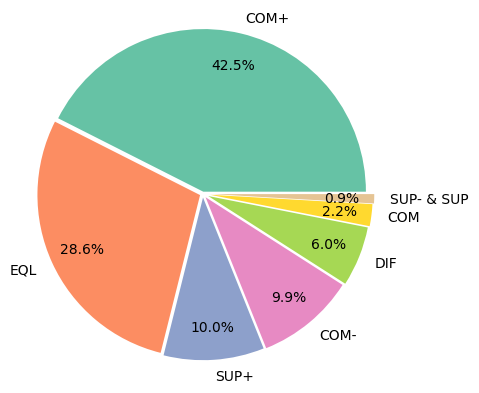

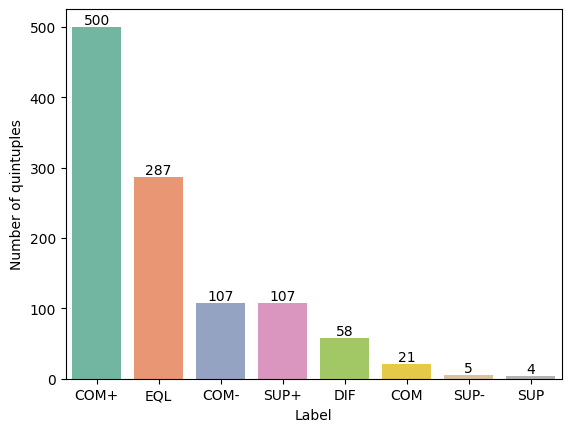

In [ ]:
flattened_df = pd.DataFrame(flattened_train_dataset)

def relate_labels_with_others(flattened_df: pd.DataFrame):
  statistic: list[dict] = [{
      "label": label,
      "num_of_data_points": len(flattened_df[flattened_df.label == label]),
      "num_of_sentences": len(flattened_df[flattened_df.label == label].sentence.unique())

  } for label in list(flattened_df[flattened_df.label.str.contains("^.{1,}$", na=False)].label.unique())]

  statistic = pd.DataFrame(statistic).sort_values(by="num_of_data_points", ascending=False)

  print("Present num_of_data_points (number of quintuples) and num_of_sentences on each label type:")
  # print(statistic)
  # print()

  ## Group SUP- & SUP (each has 4 sentences) before rendering
  x = statistic.set_index("label").drop(["SUP-", "SUP"]).reset_index()
  minor_data = statistic[statistic.label.str.match("^(SUP-)|(SUP)$", na=False)]#.reset_index()
  minor_data_grouping_point = pd.DataFrame([{
      "label": "SUP- & SUP",
      "num_of_data_points": reduce(lambda acc, val: acc + val, minor_data["num_of_data_points"].tolist()),
      "num_of_sentences": reduce(lambda acc, val: acc + val, minor_data["num_of_sentences"].tolist())
  }])

  x = pd.concat([x, minor_data_grouping_point], ignore_index=True)
  print(f"(group 'SUP-' and 'SUP')\n{x}\n")

  ## Render diagrams
  color_pallete = sbn.color_palette('Set2')
  explodes = [0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06]

  plt.pie(x["num_of_sentences"], labels=x.label.tolist(),
          colors=color_pallete, autopct='%.1f%%',
          radius=1.1, pctdistance=0.8, labeldistance=1.1, explode=explodes, shadow=False)
  # plt.title('Số lượng data point trên từng label')
  plt.show()
  print()

  plot = sbn.countplot(flattened_df, x = "label", # ignore NaN, None by default
                      order=list(flattened_df.value_counts("label").index),
                      palette=color_pallete)
  plot.set(title = "", xlabel = "Label", ylabel = "Number of quintuples") # may contains duplicate sentences
  plot.bar_label(plot.containers[0])

  plt.show()

relate_labels_with_others(flattened_df)

###### ii. Relate labels to the remaining quintuple fields

**Labels vs predicates**

- Common characteristics:
  - Predicates in general show key opinions of authors/reviewers about the comparisons between 2 products/product lines...
  - In predicates, adverbs along with adjectives takes up most of the words. Specifically, some of them are:
    - Adverbs of degree: hơi, rất, khá, nhất
    - Adverbs of manner: tốt
    - Adjectives (may be specific to context): mạnh mẽ, khác biệt

- Predicates in the label "EQL" (287q):
  - Examples of common words:
    - (hầu như) không có sự khác biệt
    - không có sự khác biệt nhiều
    - Tương tự/tương đồng
    - Ngang/giống/bằng nhau
      
      ...


- Predicates in the label "DIF":
  - Examples of common words:
    - *khác biệt*, *khác nhau*
    - không bằng (như)
      
      ...


- Predicates in the label "COM+" (500q):
  - Examples of common words:
    - (hầu như) không có sự khác biệt
    - Tương tự/tương đồng
    - Ngang/giống/bằng nhau
      
      ...


Label 'DIF' (58):
Some examples:
- hiếm có chiếc điện thoại nào trên thị trường có thể làm được
- thiếu
- ngược lại
- khác biệt dễ nhận thấy
- không hoàn toàn ngang bằng
- chênh lệch rõ ràng
- không có
- lột xác hoàn toàn
- không bị ngả sang tone vàng như
- không bị bệt hay mất chi tiết như

- Field 'subject':
  + Freq: 48
  + BoW:
    {'pro': 11, 'galaxy': 11, 'hai': 7, 'điện': 6, 'thoại': 6, 'max': 6, 'iphone': 5, 'này': 5, 'bộ': 5, 'đôi': 5, 'dòng': 4, 'bản': 4, '13': 3, 's21': 3, 'ultra': 3, 'của': 3, 'cả': 3, 'phiên': 3, 'máy': 3, 'a23': 3, 'chiếc': 3, 'này': 2, '11': 2, 'và': 2, '2': 2, 'z': 2, 'samsung': 2, '14': 2, 'biến': 2, 'thể': 2, '“': 2, 'for': 2, '”': 2, 's10': 2, 'plus': 2, 'màn': 2, 'hình': 2, 'vivo': 1, 'y21': 1, 'xiaomi': 1, 'model': 1, 'nó': 1, '8': 1, 'camera': 1, 'selfie': 1, 'trước': 1, 'apple': 1, 'find': 1, 'x6': 1, 'những': 1, 'a53': 1, 'sản': 1, 'phẩm': 1, 'nửa': 1, 'flip': 1, 's22': 1, '+': 1, 'chipset': 1, 'a31': 1, 'thiết': 1, 'kế': 1, 'fold3': 1, 'a

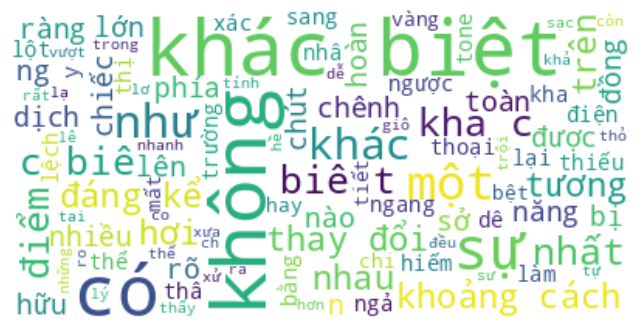

In [372]:
for label in ["DIF"]:
  df_l = flattened_df[flattened_df.label == label]

  print(f"Label '{label}' ({len(df_l)}):")

  print("Some examples:")
  [print(f"- {s}") for s in df_l.predicate.unique().tolist()[:10]]
  print()

  for field in ["subject", "object", "aspect"]:
    print(f"- Field '{field}':")
    print(f"  + Freq: {calc_frequency(field, label)}")
    print(f"  + BoW:\n    {calc_BoW(field, label)}")

  print("- Field 'predicate':")
  print(f"  + BoW:\n    {calc_BoW('predicate', label)}\n")
  render_wordcloud(df_l[df_l.predicate.str.contains("^.{1,}$", na=False)].predicate.tolist(),
                   stopwords=[],
                   max_font_size=50, max_words=350, background_color="white")
  print("\n\n")

### Problems

Problems with data? Which needs to be cleaned? Solutions?
- Imbalance (having at least 1 vs no quintuple; 'label' biases "COM+" value)
  
  -> removing, sampling & augmentation ... ?

- Difference in definition of "word" & "token" in Vietnamese vs English; most of product names is English while remaining is Vietnamese.
  - how to handle "từ ghép"? segmentation. -> which lib or technique? consistency between sentence & quintuple (especially product name, ...)?
  - stopwords? which ones should be removed? (considered in VNese)
- Lack of data (or unimportant data...), especially in lines containing "des:", "title:"...

  ->

- Duplicate: some sentences are quite similar; they even are substring of others.

  ->



## Data cleaning
Next update: may add augmentation



#### `clean_data(dataset: str): list` *(TODO: modify this)*

- **Input**:
  - `MINIMUM_NUM_OF_TOKENS`: local variable, which determines whether to keep a sentence based on its number of token.
- **Output**:


In [ ]:
from multipledispatch import dispatch

# @dispatch(list)
def clean_data(dataset_array: list[DataPoint] = []):
  MINIMUM_NUM_OF_TOKENS: int = 5

  for i in range(len(dataset_array)):
    current_line = dataset_array[i].strip()

    """ 1. Remove some redundant words """
    current_line = re.sub(r'(alt:)|(des:)|(title:)', '', current_line).strip()
    ###

    """"""

    """ 3. Normalize text """
    # dest_sentence = uts.text_normalize(dest_sentence) # include tokenization
    """"""

    """ (removed) 3. Remove stopwords from the list of tokens and also the original sentence """
    # Is it necessary to tokenizing before stopword removal??? What if considering directly original sentences?
    # non_stopword_tokens = [t for t in tokens if stopwords.count(t.lower()) == 0]
    # dest_sentence = str.join(" ", non_stopword_tokens)
    """"""

    """ 4. Validate sentence length"""
    # Do not obtain a sentence if it has less than MINIMUM_NUM_OF_TOKENS tokens
    # Temporarily keep words containing only digits & letters to count total token of lexical word

    # Tokenize Vietnamese sentence
    tokens: list = nltk.word_tokenize(dest_sentence)

    # validated_sentence = re.sub(r'[^\w\s]', '', dest_sentence) # old
    lexical_tokens = [token for token in tokens if re.match(r"\w*", token)]

    if len(lexical_tokens) < MINIMUM_NUM_OF_TOKENS: continue

    # dest_sentence = re.sub(r'[^\w\s\d?.,!;:]', '', dest_sentence)
    """"""

  # return


# @dispatch(str)
# def parse_and_clean_data(dataset: str = ""):
#   # split by "\n" to sequentially read each line of the input
#   dataset_array: list = dataset.split("\n")

#   return parse_and_clean_data(dataset_array)

## Post-cleaned data analysis

In [ ]:
# Check if any sentence is duplicated
# origin_idx: key, value(origin_sent, relationship, sub_str_idx, sub_str_sent)
result: list = []

for i in range(len(training_dataset)):
  current_sentence: str = training_dataset[i].sentence.lower()

  for j in range(i - 1, -1, -1):
    prev_sentence: str = training_dataset[j].sentence.lower()
    rel = None

    if prev_sentence == current_sentence: rel = "equal"
    elif prev_sentence in current_sentence: rel = "contains"
    elif current_sentence in prev_sentence: rel = "contained"

    if not rel is None: result.append({
        "origin_idx": i,
        "origin_sent": training_dataset[i].sentence,
        "rel": rel,
        "2nd_sent_idx": j,
        "2nd_sent": training_dataset[j].sentence
    })

pd.DataFrame(result)

,origin_idx,origin_sent,rel,2nd_sent_idx,2nd_sent
0,6,"Trong ba smartphone ngày hôm nay, Motorola One...",contains,3,Thiết kế
1,7,Nó không sử dụng thiết kế notch hình đục lỗ mà...,contains,3,Thiết kế
2,11,Màn hình,contained,6,"Trong ba smartphone ngày hôm nay, Motorola One..."
3,15,Chính vì vậy mà di động Samsung chiến thắng tr...,contains,11,Màn hình
4,16,"Realme 6 Pro có màn hình IPS, nhưng nó có tốc ...",contains,11,Màn hình
...,...,...,...,...,...
158925,4166,des: Yên tâm mua hàng tại Thế Giới Di Động,contains,53,des:
158926,4167,Yên tâm mua hàng tại Thế Giới Di Động.,contains,1286,Thế giới di động.
158927,4168,Lưu ý : Bạn có thể cập nhật chi tiết chính sác...,equal,2707,LƯU Ý : Bạn có thể cập nhật chi tiết chính sác...
158928,4170,Hẹn gặp lại bạn ở các bài viết sau!,equal,3343,Hẹn gặp lại bạn ở các bài viết sau!


In [ ]:
from tensorflow import keras
from typing import List
from keras.preprocessing.text import Tokenizer

sentence = ["John likes to watch movies. Mary likes movies too (likes movies)."]

def print_bow(sentence: List[str]) -> None:
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentence)
    sequences = tokenizer.texts_to_sequences(sentence)
    word_index = tokenizer.word_index

    print(f"Vocab: {word_index}")
    print(sequences)

    bow = {}
    for key in word_index:
        bow[key] = sequences[0].count(word_index[key])

    print(f"Bag of word for sentence 1:\n{bow}")
    print(f"We found {len(word_index)} unique tokens.")

print_bow(sentence)

{'likes': 1, 'movies': 2, 'john': 3, 'to': 4, 'watch': 5, 'mary': 6, 'too': 7}
[[3, 1, 4, 5, 2, 6, 1, 2, 7, 1, 2]]
Bag of word sentence 1:
{'likes': 3, 'movies': 3, 'john': 1, 'to': 1, 'watch': 1, 'mary': 1, 'too': 1}
We found 7 unique tokens.
